# Cancer Prediction from Scratch: the good, the bad and the ugly 

The notebook is made to demonstrate the next skills:

- Perform proper data preprocessing.
- Descriptive Analytics
- Predictive Analytics
- Perform natural language processing.
- Use map and reduce operations.
- Use streaming data.
- Translate data into a graph and extract information from a network.
- Apply machine learning
- My ability to detect and handle imabalanced data.
- Data Reduction using the PCA algorithm (The Principal Component Analysis)
- Data Visualization with Matplotlib

*From my point of view the application of graph theory is very handy to improve logistics in companies. Specially if we are talking about analyzing information from point A to point B.

### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk.sentiment.util
from nltk.tag import pos_tag
import networkx as nx
import itertools
import random
import imblearn
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from sklearn.decomposition import TruncatedSVD
import seaborn as sb
import matplotlib.pyplot as plt
from clustergrammer_widget import *
import ipywidgets as widgets
import matplotlib.pyplot as plt

 # Cancer Gene Detection
 
 To start coding. I am going to discuss a little bit about the idea behind the scence. I took this dataset available online which has the interactions within human proteins. I am interested in finding out those proteins which are more related to cancer given certain characteristics of the interaction network, to do this I need to detect whether the description containing the word cancer relates positively or negatively to the protein description, in order to classify them as cancer/no cancer(sentiment analysis). Then I am going to do natural language processing to add certain caracteristics given the protein description as an attribute to the node. Afterwards, I am going to proceed to perform some machine learning algorithm to find out those proteins interactions which tend to be, more exposed to turn into cancer given the characteristics of my network.

### Dataset

I took the dataset from the next link https://string-db.org/cgi/download?sessionId=%24input-%3E%7BsessionId%7D&species_text=Homo+sapiens, which takes into account only those proteins from Humans. I do have a list of links with the proteins and their interactions, together with their ID's and descriptions, I will try to find out the cancer labels by doing sentiment analysis over the descriptions. 
   a) First dataset contains the proteins with its descriptions.
   b) Second dataset contains the protein interactions. 

In [2]:
#First Clean the file with the information of each protein.
proteinsInfoOriginal = open("9606.protein.info.v11.0.txt", "r").readlines()

In [3]:
#Second dataset with protein interactions
proteinNetwork = pd.read_csv('9606.protein.links.detailed.v11.0.txt', sep=' ', header='infer')

### NATURAL LANGUAGE PROCESSING: ASSINGING THE LABELS 

First we are going to build a dataset out of our txt file. 

In [4]:
#Creating dataset into dataframe.
stopwords = set(nltk.corpus.stopwords.words('english'))

def edit_line(line):
    return str(line).split("\t")
def tokenization(txt):
    return word_tokenize(str(txt).lower())
def lemmatization(txt):
    return [WordNetLemmatizer().lemmatize(t) for t in txt]
def stopwords_txt(txt):
    return (set(txt)-stopwords)
def contains_cancer(txt): 
    return 'cancer' in list(txt)

data = list(map(edit_line,proteinsInfoOriginal))

In [5]:
proteinDescription = pd.DataFrame(data[1:], columns = data[0])

In [6]:
#Tokenization process
proteinDescription['annotation\n'] = list(map(tokenization,proteinDescription['annotation\n']))

In [7]:
# LemmatizaproteinDescription['annotation\n']tion process (I use lemmatization instead of steam, because is more precise)
proteinDescription['annotation\n'] = list(map(lemmatization,proteinDescription['annotation\n']))

In [8]:
# Stop words erasing
proteinDescription['annotation\n'] = list(map(stopwords_txt,proteinDescription['annotation\n']))

In [9]:
# I want to identify classify the proteins which contain the word cancer. 
# Those I am going to add a cancer label indicator on the description to filter and then perform sentiment analysis
# over the descriptions which contain the word cancer. 
proteinDescription['cancer_label'] = list(map(contains_cancer,proteinDescription['annotation\n']))
#These are the proteins which are related to cancer by description, now I need to identify whether the content
# is negative or positive.
cancer_proteins = proteinDescription[proteinDescription['cancer_label'] == True]

In [10]:
cancer_proteins['index_list'] = cancer_proteins.index

<ipython-input-10-e2df2b7b983d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_proteins['index_list'] = cancer_proteins.index


In [11]:
list_cancer = list(cancer_proteins['index_list'])

In [12]:
proteinDescription_x = pd.DataFrame(data[1:], columns = data[0])
proteinDescription_x = proteinDescription_x[ proteinDescription_x.index.isin(list_cancer)]

In [13]:
# I got the dataset with proteins related to cancer for manually map words/tokens related to cancer as positive or negative. 
proteinDescription_x_tok = list(map(tokenization,proteinDescription['annotation\n']))
proteinDescription_x.to_csv("cancer_list.csv")

### Opinion Lexicon Generation: Dictionary based approach

To create my opinion words. I decided to proof two types of opinion words, the first type which will include words that describe cancer including nouns, adjectives and adverbs and the second type which will include only adjective and adverbs. According with research done in reviews the opinion words that best work to identify sentiment are the adjectives/adverbs. However, due to my application which is about to analyse descriptions, I might detect nouns or verbs which are a clear indicator of positive or negative cancer. Therefore, my first type of opinion words exists. 

For type 1 : I inspect manually the 169 descriptions related to cancer and annotated the words related positive or negative to cancer. I do have my two lists and I am going to increase my set of opinion words using the dictionary based approach described in https://www.cs.uic.edu/~liub/FBS/NLP-handbook-sentiment-analysis.pdf. Due to my application, which is to define concrete descriptions, I decided to iterate one time. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0197816

For type 2: I proceed with the same technique except that I take into account only verbs and adverbs.

In [14]:
len(proteinDescription_x['annotation\n'])

169

In [15]:
#Opinion words type 1.
# Proteins which protect from cancer
pos_words = list(['protect', 'least', 'preventing', 'decreases', 'stabilizes', 'inhibits', 'suppress', 'mediated','suppressor', 'degrades', 'repressor', 'mediated', 'resistance'])
#Proteins which produce cancer
neg_words = list(['proliferation', 'promote', 'transition', 'differentation', 'malignancy','susceptibility','progression', 'metastasis', 'inactive', 'progenitor', 'disease', 'headcase', 'associated', 'downstream', 'repeat'])

In [16]:
#Creating list of words 
words_in_cancer_description = []
for item in cancer_proteins['annotation\n']:          
    postag = nltk.pos_tag(list(item))
    postag_class = [item[1] for item in postag]
    postag_word = [item[0] for item in postag]
    for word in postag:
        #specify that we only want adverbs and adjectives
        if word[1] == 'JJ' or word[1] == 'RB':
            words_in_cancer_description.append(word[0])
        else:
            pass

In [17]:
pd.DataFrame(set(words_in_cancer_description)).to_csv('cancer_adjectives.csv')
#Manually inspect the words and leave the adjectives that were coherent as positive or negative

# #TODO ADD THE TYPE 2 OPINION WORDS

In [18]:
#Opinion words type 2.
#Proteins which protect from cancer

#PRotein which produce cancer


In [19]:
def getSynonims(word):
    syn = []
    for word in wordnet.synsets(word):
        for lemma in word.lemmas():
            syn.append(lemma.name())
    return syn
#List of words gathered out of visual inspection. 
synonims_pos = []
synonims_neg = []

for word in pos_words:
    synonims_pos.append(getSynonims(word))
for word in neg_words:
    synonims_neg.append(getSynonims(word))
pos_words_list = set(list(itertools.chain(*synonims_pos)))
neg_words_list = set(list(itertools.chain(*synonims_neg)))

In [20]:
#some data cleaning on the lexicon lists. Because not all the synonim words retrieved are useful. 
pos_words_list = list(['arbitrate',
 'brace',
 'decrease',
 'decrement',
 'degrade',
 'demean',
 'diminish',
 'diminution',
 'drop-off',
 'electric_resistance',
 'electrical_resistance',
 'fall',
 'forbid',
 'immunity',
 'impedance',
 'inhibit',
 'intercede',
 'intermediate',
 'keep',
 'least',
 'lessen',
 'lessening',
 'liaise',
 'mediate',
 'mediated',
 'minify',
 'ohmic_resistance',
 'opposition',
 'oppress',
 'preclude',
 'prevent',
 'protect',
 'put_down',
 'reduction',
 'repress',
 'represser',
 'repressor',
 'resistance',
 'resistivity',
 'resistor',
 'stabilise',
 'stabilize',
 'stamp_down',
 'steady',
 'step-down',
 'subdue',
 'suppress',
 'suppresser',
 'suppresser_gene',
 'suppressor',
 'suppressor_gene',
 'take_down',
 'to_the_lowest_degree',
 'underground'])

In [21]:
neg_words_list = list(['advance',
 'advancement',
 'advertise',
 'advertize',
 'affiliate',
 'associate',
 'assort',
 'boost',
 'changeover',
 'colligate',
 'connect',
 'consort',
 'conversion',
 'disease',
 'dormant',
 'downriver',
 'downstream',
 'elevate',
 'forward_motion',
 'further',
 'inactive',
 'ingeminate',
 'iterate',
 'kick_upstairs',
 'link',
 'link_up',
 'malignance',
 'malignancy',
 'malignity',
 'metastasis',
 'modulation',
 'motionless',
 'onward_motion',
 'passive',
 'patterned_advance',
 'primogenitor',
 'procession',
 'progenitor',
 'progress',
 'progression',
 'proliferation',
 'promote',
 'push',
 'raise',
 'recur',
 'reduplicate',
 'reiterate',
 'relate',
 'repeat',
 'repetition',
 'replicate',
 'reprise',
 'reprize',
 'restate',
 'retell',
 'static',
 'still',
 'susceptibility',
 'susceptibleness',
 'take_over',
 'tie_in',
 'transition',
 'upgrade'])

In [22]:
#I am going to apply pos-tag to my words, because I need to keep adjectives, adverbs and nouns. I include nouns 
# because I am working with descriptions and nouns attach with negative cancer description are crucial. 
neg_tags = nltk.pos_tag(neg_words_list)
pos_tags = nltk.pos_tag(pos_words_list)

In [23]:
neg_tags = [item for item in neg_tags if item[1] != 'VB']
pos_tags = [item for item in pos_tags if item[1] != 'VB']

In [24]:
def get_pos_tags(tags_descriptions):
    array_dummy = []
    for element in tags_descriptions:
        tags = nltk.pos_tag(list(element))
        array_dummy.append(tags)
    return array_dummy
def pos_tags_filter(tags_array):
    array_dummy = []
    for element in tags_array:
        array_dummy.append([item[0] for item in element if item[1] == 'JJ' or item[1] == 'NN' or item[1] == 'RB'])
    return array_dummy

In [25]:
#adding postag to my descriptions and filtering verbs.
proteinDescription['annotation\n'] = get_pos_tags(proteinDescription['annotation\n'])
#left the pos tag out of my array
proteinDescription['annotation\n'] = pos_tags_filter(proteinDescription['annotation\n'])

In [26]:
proteinDescription[proteinDescription['cancer_label'] == True]

,protein_external_id,preferred_name,protein_size,annotation\n,cancer_label
102,9606.ENSP00000064778,FAM168A,244,"[protein, pathway, level, ubiquitation, act, c...",True
156,9606.ENSP00000167106,VASH1,365,"[migration, macrophage, vitro, artery, exhibit...",True
241,9606.ENSP00000201031,TFAP2C,450,"[protein, gene, important, development, c/ebp,...",True
441,9606.ENSP00000216807,BRMS1L,323,"[lung, protein, lack, histone, repression, gro...",True
514,9606.ENSP00000219022,OLFM4,510,"[promote, myeloid, probably, growth, interacti...",True
...,...,...,...,...,...
18144,9606.ENSP00000463027,NCOA4,650,"[gamma, androgen, nuclear, prostate, cell, ppa...",True
18188,9606.ENSP00000464162,GREB1L,1923,"[family, greb1, breast, regulation, growth, es...",True
18533,9606.ENSP00000473553,CSNK2A3,391,"[lung, protein, development, ii, kinase, large...",True
19289,9606.ENSP00000484135,COLCA2,251,"[colorectal, cancer]",True


Now I need to assign to my lexicon a weight of importance to each of my lexicon words to define which is the most negative and the most positive word to do this, I am going to proceed to check the frequency of my words in my dataset. Thus, I am going to use map and reduce operations from pyspark to count the frequency of my lexicon words in my text and then be able to assign a preference over each most negative words and most positive words. 

In [27]:
# By visual inspection and the frequency of my words, I will assign categories on my words from 1-5 (stars).

In [28]:
def get_words(array):
    words = ""
    for item in array:
        for word in item:
            words += ' ' + word
    return words
        
words = get_words(proteinDescription['annotation\n'])

In [29]:
text_file = open("words.txt", "w")
n = text_file.write(words)
text_file.close()

The part of the sentiment analysis is based on the next works:
    1) A lexicon based method to search for extreme opinions 
       https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0197816}
    2) Mining and Summarizing Customer Review
       https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf
    3) Opinion Observer: Analyzing and Comparing Opinions  on the Web 
       https://www.cs.uic.edu/~liub/publications/www05-p536.pdf

### Sentiment Analysis over Descriptions: an Unsupervised Lexicon Based Approach

I have to explain that the natural language processing is a whole world in the data science area. There is NLP to do chatbots, NLP to apply sentiment analysis, NLP to summarized objects, NLP to identify document classification by topics and recently NLP to make robots talk as humans, translation from text to voice and voice to text. Given that I am analysing descriptions, I decided to use NLP as a person will use it with a review. In the previous mentioned works we can appreciate the analysis of different kind of reviews over products. Depending on the type of review you might perform one or another technique, if your review talks about the same product, if your review compares products or if your review has a well establish separation between cons and pros over a product. It is important to understand that it is not the same working with direct opinion sentences or subjective sentences  in reviews. Given my application which has basically protein descriptions related to cancer, I want to be able to identify whether the protein produce or helps to proliferate cancer, based on the description without the need of manually classify my protein descriptions. In this analysis I am taking into account the next situation. My descriptions are the same as a direct opinion review, because they explicitly describe proteins and its properties. In previous works about identifying sentiment of product reviews it is important to identify the "features" (properties of the products) that are positive or negative related to the product. In my case the only feature that I am interested to know whether its relation is positive or negative with respect to the description is the noun/feature cancer. Thus, I am going to use it as a single feature with my descriptions the word cancer. 

In [30]:
import findspark
findspark.init()
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate()

In [31]:
file = sc.textFile('words.txt').flatMap(lambda line: line.split(" "))

In [32]:
file.count()

332866

In [33]:
file_num = file.map(lambda s: (s,1))

In [34]:
word_count = file_num.reduceByKey(lambda a,b:a + b)

In [35]:
#get the words as df 
df_word_count = word_count.toDF(['attribute','count'])

In [36]:
count_word_pd = df_word_count.toPandas()

In [37]:
count_word_pd

,attribute,count
0,,1
1,factor,2207
2,adp-,16
3,catalytic,332
4,family,6061
...,...,...
31654,saa2-saa4,1
31655,c17orf100,1
31656,tmem1,1
31657,respiratoy,1


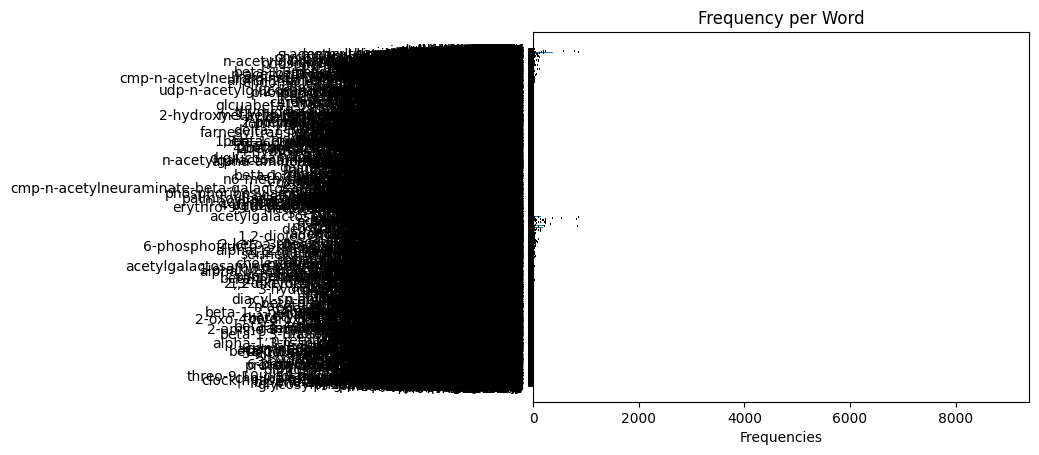

In [38]:
#the frequency per word looks as follows. Unfortunately, I cannot talk about a distribution, given that I do not
#know the description order. 
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
word = count_word_pd['attribute']
y_pos = np.arange(len(word))
frequency = count_word_pd['count']
error = np.random.rand(len(word))

ax.barh(y_pos, frequency, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(word)
ax.invert_yaxis()  
ax.set_xlabel('Frequencies')
ax.set_title('Frequency per Word')

plt.show()



In [39]:
#we can see here the frequency of words given its pos_Tag, verbs, adverbs, adjectives, nouns etc. Again, we cannot
#write about distributions because we do not know the order. 
def return_tokens(word):
    word = nltk.word_tokenize(word)
    return nltk.pos_tag(word)
pos_tags_words = list(map(return_tokens,count_word_pd['attribute']))

In [40]:
count_word_pd['pos_tags'] = pos_tags_words

In [41]:
count_word_pd = count_word_pd.drop(index=0)

In [42]:
count_word_pd = count_word_pd.reset_index()

In [43]:
def get_word_type(list_type):
    return list_type[-1][1]
count_word_pd['tag_description'] = list(map(get_word_type,count_word_pd['pos_tags']))

In [44]:
count_word_pd

,index,attribute,count,pos_tags,tag_description
0,1,factor,2207,"[(factor, NN)]",NN
1,2,adp-,16,"[(adp-, NN)]",NN
2,3,catalytic,332,"[(catalytic, JJ)]",JJ
3,4,family,6061,"[(family, NN)]",NN
4,5,allosteric,26,"[(allosteric, NN)]",NN
...,...,...,...,...,...
31653,31654,saa2-saa4,1,"[(saa2-saa4, NN)]",NN
31654,31655,c17orf100,1,"[(c17orf100, NN)]",NN
31655,31656,tmem1,1,"[(tmem1, NN)]",NN
31656,31657,respiratoy,1,"[(respiratoy, NN)]",NN


In [45]:
#less popular word, which is the less favorite word from scientist to use in protein descriptions
count_word_pd.sort_values(by='count')
#hco

,index,attribute,count,pos_tags,tag_description
15828,15829,hco,1,"[(hco, NN)]",NN
19641,19642,homotypically,1,"[(homotypically, RB)]",RB
19639,19640,rab4/rab5,1,"[(rab4/rab5, NN)]",NN
19638,19639,c3orf20,1,"[(c3orf20, NN)]",NN
19636,19637,calpain-7,1,"[(calpain-7, NN)]",NN
...,...,...,...,...,...
15757,15758,complex,3011,"[(complex, JJ)]",JJ
15754,15755,cell,3707,"[(cell, NN)]",NN
15779,15780,role,4326,"[(role, NN)]",NN
3,4,family,6061,"[(family, NN)]",NN


In [46]:
#less popular word, which is the less favorite word from scientist to use in protein descriptions
count_word_pd.sort_values(by='count', ascending=False)
#protein

,index,attribute,count,pos_tags,tag_description
15737,15738,protein,8946,"[(protein, NN)]",NN
3,4,family,6061,"[(family, NN)]",NN
15779,15780,role,4326,"[(role, NN)]",NN
15754,15755,cell,3707,"[(cell, NN)]",NN
15757,15758,complex,3011,"[(complex, JJ)]",JJ
...,...,...,...,...,...
18828,18829,tfg,1,"[(tfg, NN)]",NN
9705,9706,phosphatidyetanolamline,1,"[(phosphatidyetanolamline, NN)]",NN
9706,9707,tml,1,"[(tml, NN)]",NN
9707,9708,hydroxytrimethyllysine,1,"[(hydroxytrimethyllysine, NN)]",NN


In [47]:
#check unique values of tag_description
count_word_pd['tag_description'].unique()

array(['NN', 'JJ', 'RB', 'CD', 'VBG', 'NNS', 'VBN', 'IN', '.', 'VB',
       'JJR', 'DT', 'VBD', 'JJS'], dtype=object)

In [48]:
#create dataframe with specific names https://www.nltk.org/api/nltk.tag.html
tag_names = count_word_pd['tag_description'].unique()
word_classification = ['noun','adjective','adverb','cardinal digit','gerund','noun plural','verb past participle','preposition','dot','verb','adjective comparative','determiner','verb past','adjective superlative']
names_frame = pd.DataFrame({'tag_description':tag_names,'word_type':word_classification})

In [49]:
final_words = count_word_pd.join(names_frame.set_index('tag_description'), on='tag_description', how='left')

In [50]:
word_type_frequency = final_words[['count','word_type']].groupby('word_type').agg({'count': ['sum']}).reset_index()

In [51]:
word_type_frequency.columns = ['word_type','count_sum']

In [52]:
word_type_frequency['percentage'] = word_type_frequency['count_sum']/332866

In [53]:
#normalization, just in case
word_type_frequency['count_sum_norm'] = (word_type_frequency['count_sum']-word_type_frequency['count_sum'].min())/(word_type_frequency['count_sum'].max()-word_type_frequency['count_sum'].min())
#word_type_frequency.columns = ['count_sum','percentage','count_sum_norm']
#word_type_frequency['word_type'] = word_type_frequency.index
word_type_frequency

,word_type,count_sum,percentage,count_sum_norm
0,adjective,43776,0.131512,0.161774
1,adjective comparative,8,0.000024,0.000022
2,adjective superlative,2,0.000006,0.000000
3,adverb,12308,0.036976,0.045479
4,cardinal digit,24,0.000072,0.000081
5,determiner,14,0.000042,0.000044
6,dot,76,0.000228,0.000273
7,gerund,2149,0.006456,0.007935
8,noun,270589,0.812907,1.000000
9,noun plural,1627,0.004888,0.006005


In [54]:
type(np.array(list(word_type_frequency['count_sum'])))

numpy.ndarray

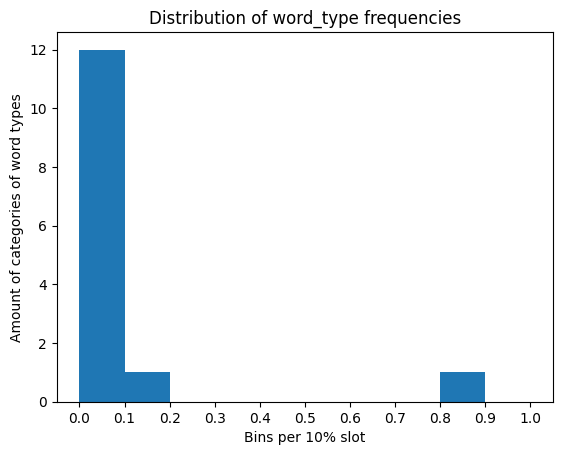

In [55]:
#Distribution of each word_type, as we can see most of the values near by zero. 
#It is a Skewed distribution to the left.
fig,ax = plt.subplots(1,1)
a = np.array(word_type_frequency['percentage'])
ax.hist(a, bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title("Distribution of word_type frequencies")
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_xlabel('Bins per 10% slot')
ax.set_ylabel('Amount of categories of word types')
plt.show()


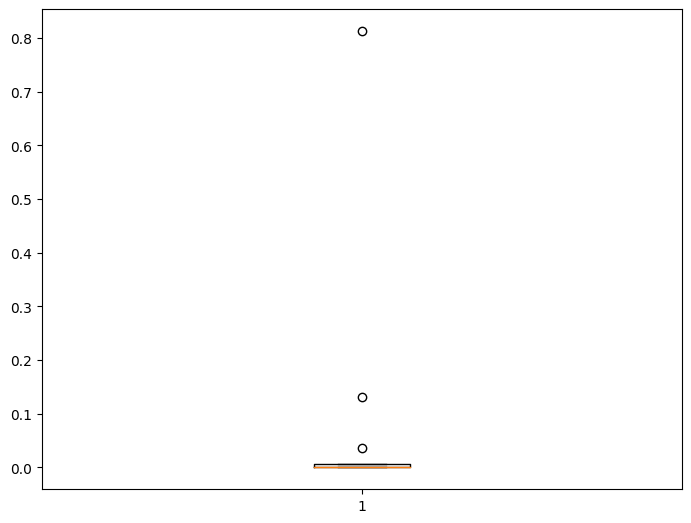

In [56]:
#Box plot to see the statistical properties. 
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
# Create the boxplot
bp = ax.boxplot(word_type_frequency['percentage'])
plt.show()

In [57]:
mean_percentage =  word_type_frequency['percentage'].mean()
median_percentage =  word_type_frequency['percentage'].median()
std_percentage = word_type_frequency['percentage'].std()
Q1 = word_type_frequency['percentage'].quantile(0.25)
Q3 = word_type_frequency['percentage'].quantile(0.75)
IQR = Q3 - Q1

In [58]:
print(f'mean: {mean_percentage}, median: {median_percentage}, Q1: {Q1}, Q3: {Q3}, IQR = {IQR}, STD = {std_percentage}')

mean: 0.07142835684200678, median: 0.000675947678645461, Q1: 4.9569496434000474e-05, Q3: 0.0062517649744942404, IQR = 0.00620219547806024, STD = 0.21628872662294316


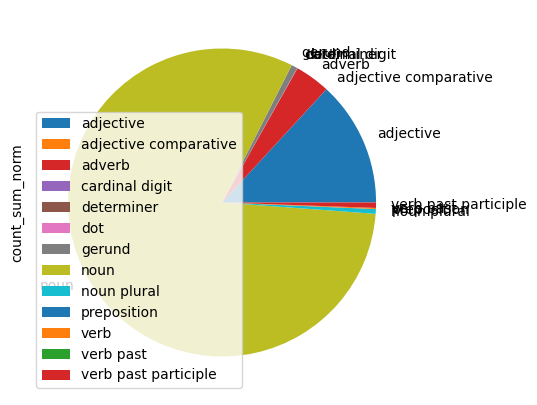

In [59]:
word_type_frequency = word_type_frequency.set_index('word_type')
plot = word_type_frequency.plot.pie(y='count_sum_norm', figsize=(11, 5))
plot.legend(loc=3)

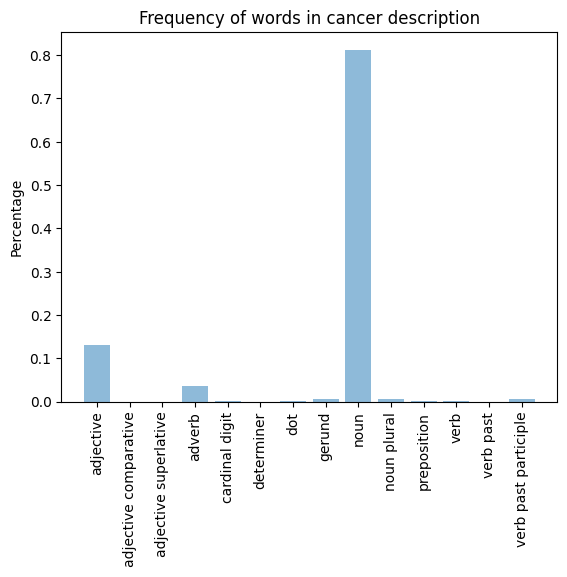

In [60]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
word_type_frequency['word_type'] = word_type_frequency.index
word_type = word_type_frequency['word_type']
y_pos = np.arange(len(word_type))
percentage = word_type_frequency['percentage']

plt.bar(y_pos, percentage, align='center', alpha=0.5)
plt.xticks(y_pos, word_type, rotation='vertical')
plt.ylabel('Percentage')
plt.title('Frequency of words in cancer description')

plt.show()

In [61]:
#get the frequency of negative words and order
neg_order = count_word_pd[count_word_pd['attribute'].isin(neg_words_list)].sort_values(by=['count'])

In [62]:
neg_order['distribution_neg_word'] = neg_order['count']/file.count()

In [63]:
neg_order

,index,attribute,count,pos_tags,tag_description,distribution_neg_word
29236,29237,advance,1,"[(advance, NN)]",NN,0.000003
14914,14915,advancement,1,"[(advancement, NN)]",NN,0.000003
28912,28913,boost,1,"[(boost, NN)]",NN,0.000003
19068,19069,raise,2,"[(raise, NN)]",NN,0.000006
4221,4222,elevate,2,"[(elevate, NN)]",NN,0.000006
3640,3641,static,2,"[(static, JJ)]",JJ,0.000006
1928,1929,passive,7,"[(passive, NN)]",NN,0.000021
20548,20549,still,7,"[(still, RB)]",RB,0.000021
1213,1214,malignancy,9,"[(malignancy, NN)]",NN,0.000027
182,183,connect,12,"[(connect, NN)]",NN,0.000036


In [64]:
#given the order of my negative words I decided to apply a category of -1 to -5 equally distributed
# I am assuming that they are equally distributed.

In [65]:
# get the frequency of postive words and order
pos_order = count_word_pd[count_word_pd['attribute'].isin(pos_words_list)].sort_values(by=['count'])

In [66]:
pos_order

,index,attribute,count,pos_tags,tag_description
28120,28121,least,1,"[(least, JJS)]",JJS
9700,9701,fall,1,"[(fall, NN)]",NN
25616,25617,steady,2,"[(steady, JJ)]",JJ
14185,14186,preclude,2,"[(preclude, NN)]",NN
25226,25227,keep,4,"[(keep, VB)]",VB
21552,21553,mediated,17,"[(mediated, VBN)]",VBN
859,860,degrade,20,"[(degrade, NN)]",NN
19570,19571,stabilize,24,"[(stabilize, VB)]",VB
247,248,suppress,42,"[(suppress, NN)]",NN
16227,16228,protect,42,"[(protect, NN)]",NN


In [67]:
len(neg_order)

26

In [68]:
#implementing sentiment analysis
protein_description_original = pd.DataFrame(data[1:], columns = data[0])

In [69]:
def contains_cancer(txt):
    txt = txt.lower()
    if "cancer" in txt:
        cancer = 1
    else: 
        cancer = 0
    return cancer

In [70]:
protein_description_original['cancer'] = list(map(contains_cancer,protein_description_original['annotation\n']))

In [71]:
protein_description_original = protein_description_original[protein_description_original['cancer'] == True]

In [72]:
neg_tags = [item[0] for item in neg_tags]
pos_tags = [item[0] for item in pos_tags]

# #TODO FINISH THE SENTIMENT ANALYSIS

In [73]:
def compute_sentiment_pos(txt):
    pos_words = pos_tags
    if '_NEG' in ''.join(nltk.sentiment.util.mark_negation(txt.split())):
        score = -1
    else:
        analysis = nltk.sentiment.util.extract_unigram_feats(txt.split(), pos_words)
        if True in analysis.values():
            score = 1
        else:
            score = 0
    return score
def compute_sentiment_neg(txt):
    neg_words = neg_tags
    analysis = nltk.sentiment.util.extract_unigram_feats(txt.split(), neg_words)
    if True in analysis.values():
        score = -1
    else:
        score = 0
    return score

In [74]:
protein_description_original['positive'] = list(map(compute_sentiment_pos,protein_description_original['annotation\n']))

In [75]:
protein_description_original['negative'] = list(map(compute_sentiment_neg,protein_description_original['annotation\n']))

In [76]:
protein_description_original['positive'].unique()

array([ 1, -1,  0])

In [77]:
protein_desc_minusone = protein_description_original[protein_description_original['positive'] == -1]

In [78]:

protein_desc_minusone

,protein_external_id,preferred_name,protein_size,annotation\n,cancer,positive,negative
156,9606.ENSP00000167106,VASH1,365,Vasohibin-1; Angiogenesis inhibitor. Inhibits ...,1,-1,-1
2210,9606.ENSP00000260187,USP2,605,Ubiquitin carboxyl-terminal hydrolase 2; Hydro...,1,-1,-1
10008,9606.ENSP00000354837,ARHGEF2,986,Rho guanine nucleotide exchange factor 2; Acti...,1,-1,-1
10303,9606.ENSP00000356234,KDM5B,1544,Lysine-specific demethylase 5B; Histone demeth...,1,-1,-1
11581,9606.ENSP00000362285,SLC29A3,475,Equilibrative nucleoside transporter 3; Mediat...,1,-1,0


In [79]:
cancer_test = protein_description_original[protein_description_original['negative'] == -1]

In [80]:
protein_desc_minusone['annotation\n']

156      Vasohibin-1; Angiogenesis inhibitor. Inhibits ...
2210     Ubiquitin carboxyl-terminal hydrolase 2; Hydro...
10008    Rho guanine nucleotide exchange factor 2; Acti...
10303    Lysine-specific demethylase 5B; Histone demeth...
11581    Equilibrative nucleoside transporter 3; Mediat...
Name: annotation\n, dtype: object

In [81]:
protein_desc_minusone['annotation\n'][156]

'Vasohibin-1; Angiogenesis inhibitor. Inhibits migration, proliferation and network formation by endothelial cells as well as angiogenesis. This inhibitory effect is selective to endothelial cells as it does not affect the migration of smooth muscle cells or fibroblasts. Does not affect the proliferation of cancer cells in vitro, but inhibits tumor growth and tumor angiogenesis. Acts in an autocrine manner. Inhibits artery neointimal formation and macrophage infiltration. Exhibits heparin-binding activity\n'

In [82]:
protein_desc_minusone['annotation\n'][2210]

'Ubiquitin carboxyl-terminal hydrolase 2; Hydrolase that deubiquitinates polyubiquitinated target proteins such as MDM2, MDM4 and CCND1. Isoform 1 and isoform 4 possess both ubiquitin-specific peptidase and isopeptidase activities (By similarity). Deubiquitinates MDM2 without reversing MDM2-mediated p53/TP53 ubiquitination and thus indirectly promotes p53/TP53 degradation and limits p53 activity. Has no deubiquitinase activity against p53/TP53. Prevents MDM2-mediated degradation of MDM4. Plays a role in the G1/S cell-cycle progression in normal and cancer cells. Regulates the circadian  [...] \n'

In [83]:
protein_desc_minusone['annotation\n'][10008]

'Rho guanine nucleotide exchange factor 2; Activates Rho-GTPases by promoting the exchange of GDP for GTP. May be involved in epithelial barrier permeability, cell motility and polarization, dendritic spine morphology, antigen presentation, leukemic cell differentiation, cell cycle regulation, innate immune response, and cancer. Binds Rac-GTPases, but does not seem to promote nucleotide exchange activity toward Rac-GTPases, which was uniquely reported in PubMed:9857026. May stimulate instead the cortical activity of Rac. Inactive toward CDC42, TC10, or Ras-GTPases. Forms an intracellula [...] \n'

In [84]:
protein_desc_minusone['annotation\n'][10303]

"Lysine-specific demethylase 5B; Histone demethylase that demethylates 'Lys-4' of histone H3, thereby playing a central role in histone code. Does not demethylate histone H3 'Lys-9' or H3 'Lys-27'. Demethylates trimethylated, dimethylated and monomethylated H3 'Lys-4'. Acts as a transcriptional corepressor for FOXG1B and PAX9. Favors the proliferation of breast cancer cells by repressing tumor suppressor genes such as BRCA1 and HOXA5. In contrast, may act as a tumor suppressor for melanoma. Represses the CLOCK-ARNTL/BMAL1 heterodimer-mediated transcriptional activation of the core clock [...] \n"

In [85]:
protein_desc_minusone['annotation\n'][11581]

'Equilibrative nucleoside transporter 3; Mediates both influx and efflux of nucleosides across the membrane (equilibrative transporter). Mediates transport of adenine, adenosine and uridine, as well as several nucleoside analog drugs, such as anticancer and antiviral agents, including cladribine, cordycepin, tubercidin and AZT. Does not transport hypoxanthine; Solute carriers\n'

In [86]:
#plus one
protein_desc_plusone = protein_description_original[protein_description_original['positive'] == 1]

In [87]:
protein_desc_minusone = protein_description_original[protein_description_original['negative'] == -1]

In [88]:
len(protein_desc_plusone)

55

In [89]:
#cancer_test.to_csv('cancer.csv')
#to do, apply sentiment analysis.

### Data Preprocessing: Working with the graph

In this part of the process, I am going to work with the data available, to build a network and extract properties out of it. There are three different ways to perform the task. In this assignment, I will address all of them to produce a final dataset, where I will have a protein with information about the amount of neighbors, how much information it sends to other proteins, how much information it receives from other proteins, special properties from the nodes (closeness, betweenness and centrality degree) and properties from the transmission action itself (neighborhood, neighborhood_transferred, fusion, cooccurence, homology, coexpression, coexpression_transferred, experiments, experiments_transferred, database, database_transferred, textmining, textmining_transferred, combined_score), which were obtained from the network description dataset. 

The first thing that I am going to do is to, define data frames which contain the nodes and the edges.

In [ ]:
nodes = list(np.array(proteinCancerFinal['protein_external_id']))
edges = list(tuple(np.array(pd.concat([proteinNetwork['protein1'], proteinNetwork['protein2']], axis=1, sort = False))))
print(type(proteinCancerFinal['protein_external_id']))
pd.DataFrame(proteinCancerFinal['protein_external_id']).to_csv('nodes.csv')
pd.concat([proteinNetwork['protein1'], proteinNetwork['protein2']], axis=1, sort = False).to_csv("edges.csv")

### Working with the Graph (Part 1): NetworkX Library and GraphFrames

I used first NetworkX library to extract properties from the network. I created a graph with the nodes and edges generated above, and I wanted to extract specific information from the network such as:
- Number of neighbors per node.
- Number of outDegrees per node (number of times that information is sent to another node).
- Number of inDegrees (number of times that information is received from another node).
- Centrality degree (location of the node within the network).
- Special properties from a node for a given network ([betweenness](https://en.m.wikipedia.org/wiki/Betweenness_cetrality) and [closeness](https://neo4j.com/docs/graph-algorithms/current/algorithms/closeness-centrality/))

From the previous information, I inferred that the nodes in the network were around 20,000 and the edges (amount of information transmitted) were 11,000,000.

#### My experience with NetworkX

I used my laptop to extract information from the network at first instant. However, due to the graph extension and the software architecture of the NetworkX library, turned out to be too complex to extract the desire features (centrality degree, closeness and betweenness).

In my studies at TU Delft I learned to use AWS. Thus, I decided to run the code in a AWS Jupyter Notebook with an EMR cluster. For the AWS configuration I used the S3 Bucket, an r3.xlarge instance (good price vs computational power) and a Jupyter Notebook (AWS). My findings were quite negative. Unfortunately, even in the cluster the properties were not extracted. I concluded that, even if the python library is called from a cluster, the computational cost of finding out the properties of each node, in a graph of around 20,000 nodes and 11 million edges turns out to be too complex. The involved library architecture does not support to work with too complex datasets, I will describe NetworkX as a good library for small datasets. The option of using GraphX from spark (well known for big data) does not support the graph property extraction such as closeness, betweenness etc. Thus, I decided to proceed with using pyspark and aggregating the edge data per node with map and reduce operations, using the network dataset (see [Working with the Graph (part2)]). From my personal point of view, finding the properties of the network and the data aggregation from the edge information will be perfect to strongly predict cancer. However, due to the current technology. I ended up using NetworkX only to extract the amount of neighbors per node.

# #TO DO IDENTIFY CLIQUES TO MAKE EFFICIENT THE COMPUTATION OF METRICS AND CHECK WHETHER A CLIQUE MIGHT BE A STRONG INDICATOR OF CANCER. GIVEN THAT I AM IN A NEIGHBORHOOD WITH CANCER, IT IS MORE PROBABLE THAT I DO HAVE CANCER. 

The next cell represents the code on the aws Jupyter Notebook previously configured to work with the EMR cluster. I am going to get the list of proteins which are related directly in a negative way to cancer. I want to map those relationshipt that might be "toxic" in such way that in my protein network those proteins in contact with "cancer proteins" already have cancer in such way that we will be able to identify a cancer relationship. 

In [90]:
cancer = pd.read_csv('cancer.csv',header='infer')

In [91]:
cancer = cancer[['protein_external_id','negative']]

In [92]:
cancer = cancer[cancer['negative'] == -1]

In [93]:
cancer['cancer'] = 1

In [94]:
cancer = cancer[['protein_external_id','cancer']]

In [95]:
cancer.columns = ['protein1','cancer']

In [96]:
proteinNetwork.columns

Index(['protein1', 'protein2', 'neighborhood', 'fusion', 'cooccurence',
       'coexpression', 'experimental', 'database', 'textmining',
       'combined_score'],
      dtype='object')

In [97]:
proteinNetworkCancer = pd.merge(proteinNetwork, cancer, on='protein1', how='left')

In [98]:
cancer2 = cancer[['protein1','cancer']]

In [99]:
cancer2['protein2'] = cancer2['protein1']
cancer2['cancer2'] = cancer2['cancer']

In [100]:
#I have to do in this dirty way because the column renaming was crashing the dataframe. Sorry!
cancer2 = cancer2[['protein2','cancer2']]

In [101]:
proteinNetworkCancer

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,NaN
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,NaN
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,NaN
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,NaN
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,NaN
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,NaN
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,NaN
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,NaN


In [102]:
proteinNetworkCancer = pd.merge(proteinNetworkCancer,cancer2, on='protein2', how='left')

In [103]:
proteinNetworkCancer['cancer_final'] = (proteinNetworkCancer['cancer'] + proteinNetworkCancer['cancer2']).fillna(0)

In [104]:
def input_cancer_val(val):
    check = 0
    if val >= 1:
        check = 1
    else:
        check = 0
    return check
proteinNetworkCancer['cancer_final'] = list(map(input_cancer_val,proteinNetworkCancer['cancer_final']))

In [105]:
proteinNetworkCancer.drop(['cancer','cancer2'], axis=1)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer_final
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,0
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,0
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,0
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,0
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,0
...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,0
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,0
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,0
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,0


In [106]:
proteinNetworkCancer[proteinNetworkCancer['cancer_final'] == 1]

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer,cancer2,cancer_final
110962,9606.ENSP00000167106,9606.ENSP00000383185,0,0,0,0,0,0,232,232,1.0,1.0,1
110971,9606.ENSP00000167106,9606.ENSP00000282397,0,0,0,0,0,0,289,289,1.0,1.0,1
367033,9606.ENSP00000219022,9606.ENSP00000309572,0,0,0,0,0,0,187,187,1.0,1.0,1
367408,9606.ENSP00000219022,9606.ENSP00000406861,0,0,0,0,0,0,212,212,1.0,1.0,1
426058,9606.ENSP00000220812,9606.ENSP00000233948,0,0,0,0,93,0,641,660,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10750844,9606.ENSP00000442521,9606.ENSP00000379133,0,0,0,0,0,0,259,259,1.0,1.0,1
10750907,9606.ENSP00000442521,9606.ENSP00000379762,0,0,0,61,0,0,233,249,1.0,1.0,1
11297763,9606.ENSP00000473553,9606.ENSP00000287394,0,0,0,64,123,0,50,152,1.0,1.0,1
11297765,9606.ENSP00000473553,9606.ENSP00000334061,0,0,0,63,157,0,0,176,1.0,1.0,1


In [107]:
proteinNetworkCancer.drop(['cancer','cancer2'], axis=1)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer_final
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,0
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,0
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,0
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,0
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,0
...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,0
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,0
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,0
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,0


In [108]:
bucket='networkanalysis'
nodes_data = 'nodes.csv'
edges_data = 'edges.csv'
nodes_data = 's3://{}/{}'.format(bucket, nodes_data)
edges_data = 's3://{}/{}'.format(bucket, edges_data)
edges = list(tuple(np.array(pd.read_csv(edges_data).iloc[:,1:])))
nodes = list(pd.read_csv(nodes_data).iloc[:,1]

SyntaxError: unexpected EOF while parsing (<ipython-input-108-0c2e71e44391>, line 7)

Build the graph with networks as nx.

In [109]:
#Create graph object. 
G = nx.MultiDiGraph()
#getting list of nodes
nodes = list(set(proteinNetworkCancer['protein1'].append(proteinNetworkCancer['protein2'])))
#getting list of edgdesmosomees
edges = list(zip(proteinNetworkCancer.protein1, proteinNetworkCancer.protein2))

In [110]:
G.add_nodes_from(nodes)

In [111]:
G.add_edges_from(edges)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [112]:
#print graph properties
print("Number of Nodes " + str(G.number_of_nodes()))
print("Number of Directed Edges: " + str(G.number_of_edges()))

Number of Nodes 19354
Number of Directed Edges: 11759454


In [ ]:
#the amount of in_degree, out_degree and neighbors is the same, because this graph is an undirected graph.
#I want to extract the amount of neighbors in the column protein1 to add the neighbors per relationship on the graph.
#I did not proceed on getting the amount of neighbors on the set of nodes and then doing a join because
#it was too expensive to compute and the computer could not perform the left join. 
#I divided my data in such ugly way because the np.split() method works for equally divided arrays. 
#It was necessary to work by chunks of information otherwise I could not compute. 

In [ ]:
def get_indegree_node(node):
    return G.in_degree(node)

In [ ]:
nodes1 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][0:1000000]))

In [ ]:
nodes2 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][1000001:2000000]))

In [ ]:
nodes3 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][2000001:3000000]))

In [ ]:
nodes4 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][3000001:4000000]))

In [ ]:
nodes5 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][4000001:5000000]))

In [ ]:
nodes6 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][5000001:6000000]))

In [ ]:
nodes7 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][6000001:7000000]))

In [ ]:
nodes8 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][7000001:8000000]))

In [ ]:
nodes9 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][8000001:9000000]))

In [ ]:
nodes10 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][9000001:10000000]))

In [ ]:
nodes11 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][10000000:11000000]))

In [ ]:
nodes12 = list(map(get_indegree_node,proteinNetworkCancer['protein1'][11000000:]))

In [ ]:
def get_indegree_node(node):
    return G.in_degree(node)
def get_outdegree_nodes(node):
    return G.out_degree(node)
def get_node_neighbors(node):
    return len(list(G.neighbors(node)))

nodes_indegree = list(map(get_indegree_node,nodes))
nodes_outdegree = list(map(get_outdegree_nodes,nodes))
nodes_neighbors = list(map(get_node_neighbors,nodes))
# Run the below commands in aws and my personal computer for several hours. It never finished.
# Network size 20000 nodes and 11 million edges. 
    
#closenessDict = nx.closeness_centrality(G)
#betweennessDict = nx.betweenness_centrality(G)
#centralityDegreeDict = nx.degree_centrality(G)

In [ ]:
#this is only to proof what I wrote above
nodes_information = pd.DataFrame({'node_id':nodes,'indegree':nodes_indegree,'outdegree':nodes_outdegree,'nodes_neighbors':nodes_neighbors})

In [ ]:
nodes_information

BY the numbers obtained above we can infer easly that proteins in a network behave as an undirect graph or the dataset is too synthetic. 

In [ ]:
pd.concat([proteinCancerFinal['protein_external_id'],pd.DataFrame(neighbors)], axis=1, sort=False).to_csv("neighbors.csv")

Given the computational cost I only extract the amount of neighbors.

#### My Experience with GraphFrames (Pyspark)

I still wanted to have more network properties to train the machine learning algorithm. Thus, I found out the [ GraphFrames](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#triangle-count) library, which works well with SQL-Pyspark. I used the library to extract the outDegrees and inDegrees and the number of triangles passing to each node. I can describe the library to be quite handy to process bigger files, but still they do not offer the previous mentioned properties (Betweenness, Closenness and Centrality Degree). The reason for that is the complexity involved in computing them. Overall, I extracted a dataset where I had a protein id with outDegrees, inDegrees and the triangle count(pending). 

In [ ]:
from graphframes import * #follow the documentation to open pyspark-shell with graphframes
edges = sqlContext.read.format("csv").option("header","true").option("inferschema","true").load("/home/abi/Documents/Network Analysis/edges.csv")
nodes = sqlContext.read.format("csv").option("header","true").option("inferschema","true").load("/home/abi/Documents/Network Analysis/nodes.csv")
#data cleaning
newedges = edges[["protein1","protein2"]]
newnodes = nodes[["protein_external_id"]]
#change newnodes header to "id" matter of the library graphframe specification. Read documentation.
oldcolumnnodes = newnodes.schema.names
newcolumnnodes = ['id']
newnodes2 = reduce(lambda newnodes, idx: newnodes.withColumnRenamed(oldcolumnnodes[idx], newcolumnnodes[idx]), xrange(len(oldcolumnnodes)), newnodes)
#change edges header to src and dst.
oldcolumnedges = newedges.schema.names
newcolumnedges = ['src', 'dst']
newedges2 = reduce(lambda newedges, idx: newedges.withColumnRenamed(oldcolumnedges[idx], newcolumnedges[idx]), xrange(len(oldcolumnedges)), newedges)
g = GraphFrame(newnodes2,newedges2)
vertexInDegrees = g.inDegrees
vertexOutDegrees = g.outDegrees
vertexOutDegrees.toPandas().to_csv("vertexOutDegrees.csv")
vertexInDegrees.toPandas().to_csv("vertexInDegrees.csv")
triangles = g.triangleCount()
triangles.toPandas().to_csv("vertexTriangles.csv")
#join Data by key, which is equal to the protein tag.
#A_B = A.join(B, A.id == B.id).select(A.*, B.b1, B.b2)
joinedDegrees = vertexInDegrees.join(vertexOutDegrees,vertexOutDegrees.id == vertexInDegrees.id)
#change schema due to id repetition.
oldcolumndegrees = joinedDegrees.schema.names
newcolumndegrees = ['id','inDegree','id1','outDegree']
joinedDegrees2 = reduce(lambda joinedDegrees, idx: joinedDegrees.withColumnRenamed(oldcolumndegrees[idx], newcolumndegrees[idx]), xrange(len(oldcolumndegrees)), joinedDegrees)
#drop id1
pandasclean = joinedDegrees2.toPandas()
pandas = pandasclean[['id','inDegree','outDegree']]
pandas.to_csv('degrees.csv')
#THE INDEGREES AND OUT DEGREES TURN OUT TO BE THE SAME. THIS FACT IS A PROOF OF HOW WONDERFUL
#AND PERFECT THE ENGINEERING NATURE IS. HOWEVER, WHEN WORKING WITH OTHER TYPES OF NETWORKS THE OUTDEGREES AND
#INDEGREES ARE RARELY THE SAME
joinTrianglesVertexIn = triangles.join(vertexInDegrees, vertexInDegrees.id == triangles.id)
joinTrianglesVertexIn.toPandas().to_csv("firstjoin.csv")
secondJoin = rddJoin.join(vertexOutDegrees, vertexOutDegrees.id == rddJoin.id)
secondJoin.toPandas().to_csv("secondJoin.csv")
#*This join operations were done witth rdds, I am aware that it can be done as well by using join alike SQL operations.

#### Information Summary

Thanks to NetworkX, I extracted the neighbors per node.
Thanks to GraphFrames I got the inDegree, outDegree and triangle count for each node.
The resulted format of the dataset is: 

node, number_of_neighbors, outDegree, inDegree, triangle_count.

### Working with the Graph (Part 2): Spark Streaming

The network file was not really big, it had a size of only 1 gb. The problem is that it was too long. Taking into account the hardware side and how registers need a space in a RAM memory to perform operations 11000000 of registers are a problem and cannot be proccessed at once by any small device pay-able by a regular human (Of course until we manage to find out the secrets of the quantum computing, but I will leave that for the future :) ). Thus, I decided to use Spark Streaming. It basically consists in reading your data by chunks of information. In my case, nicely break my long data into small subsets that I can process with spark (each chunk at a time). Below, you can appreciate the code that I created.

My intention with the code below was to produce an aggregation of the "9606.protein.links.full.v11.0.txt"(edge description data) in such way that I will end up producing a dataset including a protein name, plus the sum of each of the mentioned properties per node. In my case, I took into account the information transmitted from protein 1 to protein 2. Thus, I deleted protein 2 column.

In [ ]:
from operator import add, sub
from time import sleep
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from os import walk

sc = SparkContext(appName="streamingProteins")
ssc = StreamingContext(sc,5)
#Reshape Data
file = open("/home/abi/Documents/Network Analysis/9606.protein.links.full.v11.0.txt", "r").readlines()
del file[0]
def cleanStr(str):
    newStr = str.replace("\n","")
    newStr2 = newStr.replace(newStr[21:42],"")
    return newStr2
newFile = map(cleanStr, file)
#write Data to new txt file
with open('proteinTransmission.txt', 'w') as filehandle:
    for item in newFile:
        filehandle.write('%s\n' % item)

#create definition to save outputdata
def saveResults(rdd):
    if not rdd.isEmpty():
        rdd.toDF(["protein1","1","2","3","4","5","6","7","8","9","10","11","12","13","14"]).write.save("rddsprocess", format="csv", mode="append")
#Load proteinTransmission file
proteinTransmission = open("proteinTransmission.csv", "r").readlines()
#create file to store the rdds manually file in the spark folder with name rddsprocess.txt
#create rdd array like = queue 
rddQueue = []
# store in queue the information batches
for batch in proteinTransmission:
    rddQueue += [ssc.sparkContext.parallelize(batch)]

inputStream = ssc.queueStream(rddQueue)
inputStreamSplit = inputStream.map(lambda x: x.split(","))
inputStreamTuple = inputStreamSplit.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
inputStreamInt = inputStreamTuple.map(lambda x: (x[0], [int(i) for i in x[1]]))
totalStream = inputStreamInt.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1], a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],a[12]+b[12],a[13]+b[13],a[14]+b[14]))
totalStream.foreachRDD(saveResults)

scc.start()
scc.awaitTermination()

### Working with the Graph (Part 3): The Rudymentary Way with Pyspark and Map and Reduce Operations

Working with small computer, I decided to break the file (using os), into several files and perform data aggregation over each file to produce a reduced file. Later, I used all the reduced file to produced a second reduction and finally get the aggregated data of the network.

In [ ]:
#Define the amount of lines that my chunk files are going to have 
linesPerFile = 5000
smallfile = None
with open("proteinTransmission.txt") as file:
    for lineno, line in enumerate(file):
        if lineno % linesPerFile == 0:
            if smallfile:
                smallfile.close()
            smallName = "filereduction/smallfile_{}.txt".format(lineno + linesPerFile)
            smallfile = open(smallName, "w")
        smallfile.write(line)
    if smallfile:
        smallfile.close()
def changestr(str):
    newstr = str.replace("\n","")
    return str
#iteration over the documents to perform map and reduce operation over each of them and print the reduced rdd to 
#a newreducefile.
breakedData = os.listdir("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction")
for file in breakedData:
    workfile = "filereduction/" + file
    workfilelist = open(workfile, "r").readlines()
    newworkfilelist = map(changestr, workfilelist)
    firstRdd = sc.parallelize(newworkfilelist)
    tupleRDD = firstRdd.map(lambda x: x.split(" "))
    tupleRdd = tupleRDD.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
    intrdd = tupleRdd.map(lambda x: (x[0], [int(i) for i in x[1]]))
    #Personal comment: I still do not understand why it works with up to 13 instead of 14. But it works that way.
    total = intrdd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],b[11]+b[11],a[12]+b[12],a[13]+b[13]))
    newName = "filereduction/reduced/" + "red-" + file.replace("txt","csv")
    df = spark.createDataFrame(total)
    df.toPandas().to_csv(newName)


The output of the previous cell represented the aggregate data of each batch of information. In order to fully aggregate the data, it is necessary to append all the information together and to perform a map and reduce operation again. Each file resulted in a ~20 row key value aggregation.

#### More Data Processing to aggregate the chunks of information.

The cell below is to combine all the reduced files into one reduced file.

In [ ]:
#get the paths from reduced folder
reducedData = os.listdir("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced")
#create manually a file called result.txt contained in the reduced folder
#save full paths of reduced documents to a list
def updateListPath(pathDoc):
    str = "/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/" + pathDoc
    return str
#Update path list with the full path, initially it only contains the file names.
updated = map(updateListPath,reducedData)

#Append all the txt files together into one txt file.
with open(("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/reduced.txt"),"w") as result:
    for file in updated:
        for line in open(file, "r"):
            result.write(line)

The next code is to reduce all the information in the file. = More map and reduce.

In [ ]:
#Data preprocessing again. Now I had to clean the data again because the spark data frame returned the file with another format.
#load the resulted file and delete rows with unnecessary strings.
reducedDataDf = spark.read.csv("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/reduced.txt")
#delete rows with null values and delete column _c0 index from the previous datasets.
reducedDfDeleteRow = reducedDataDf.filter(reducedDataDf._c0 != 'null').drop(reducedDataDf._c0)
#print the table as csv file to perform text processing over the values.
reducedPandas = reducedDfDeleteRow.toPandas()
noisyTuples = list(reducedPandas["_c2"])
#clean column
def cleanTup(str):
    del1 = str.replace("Row(","")
    del1 = del1.replace("_1=","")
    del2 = del1.replace("_2=","")
    del3 = del2.replace("_3=","")
    del4 = del3.replace("_4=","")
    del5 = del4.replace("_5=","")
    del6 = del5.replace("_6=","")
    del7 = del6.replace("_7=","")
    del8 = del7.replace("_8=","")
    del9 = del8.replace("_9=","")
    del10 = del9.replace("_10=","")
    del11 = del10.replace("_11=","")
    del12 = del11.replace("_12=","")
    del13 = del12.replace("_13=","")
    del14 = del13.replace("_14=","")
    del15 = del14.replace(")","")
    del15 = del15.replace("u'","")
    return del15

clean = map(cleanTup,noisyTuples)
protein = list(reducedPandas['_c1'])
df = pandas.DataFrame(clean,protein)
#print csv ready to perform last step of map and reduce.
df.to_csv("last_step_mp.csv", sep=" ")
#load csv to perform last map and reduce operation.
#clean data again.
file = open("last_step_mp.csv", "r").readlines()

def cleanstr(str):
    str = str.replace(",","")
    str2 = str.replace('"',"")
    str3 = str2.replace("\n","")
    return str3

newFile = map(cleanstr,file)
del newFile[0]

#work with the map and reduce logic.
firstRdd = sc.parallelize(newFile)
tupleRDD = firstRdd.map(lambda x: x.split(" "))
tupleRdd = tupleRDD.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
intrdd = tupleRdd.map(lambda x: (x[0], [int(i) for i in x[1]]))
#Personal comment: I still do not understand why it works with up to 13 instead of 14. But it works that way.
total = intrdd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],b[11]+b[11],a[12]+b[12],a[13]+b[13]))
df = spark.createDataFrame(total).toPandas().to_csv("nodesnetaggregation.csv")

#*Data cleaning might be less complicated by using sql alike tables or Tableau itself.

After performing the map and reduce operations over the values, it was noted that only around 7000 nodes were involved in the network dataset. The result makes sense since all the possible proteins registered with the description are present in the first dataset. Now, I will aggregate the data to link the corresponding network properties with each protein. Overall, the four datasets that I am going to combine are the "neighbors.csv", "degrees.csv","finalData.csv"(cancer label) and the "nodesnetaggregation.csv".

### Aggregating the datasets for the machine learning algorithm (more map and reduce)

In [ ]:
#I cleaned manually the files. Erasing unnecessary columns and renaming columns.
# Creating a string list of the files
degrees = open("degrees.csv", "r").readlines()
neighbors = open("neighbors.csv","r").readlines()
nodesnet = open("nodesnetaggregation.csv").readlines()
cancer = open("finalData.csv").readlines()

# Erasing "\n" from the list of strings
def clean(str):
    newstr2 = str.replace("\n","")
    return newstr2

degreesClean = map(clean,degrees)
neighborsClean = map(clean,neighbors)
nodesnetClean = map(clean,nodesnet)
cancerClean = map (clean,cancer)
del degreesClean[0]
del neighborsClean[0]
del nodesnetClean[0]
del cancerClean[0]
# Creating first rdd of strings
degreesRdd = sc.parallelize(degreesClean)
neighborsRdd = sc.parallelize(neighborsClean)
nodesnetRdd = sc.parallelize(nodesnetClean)
cancerRdd = sc.parallelize(cancerClean)

# Spliting first rdd by ","
degreesRddSch =  degreesRdd.map(lambda x: x.split(","))
neighborsRddSch = neighborsRdd.map(lambda x: x.split(","))
nodesnetRddSch = nodesnetRdd.map(lambda x: x.split(","))
cancerRddSch = cancerRdd.map(lambda x: x.split(","))

# Turn tuple RDD to data frame.
degreesTuple = degreesRddSch.map(lambda x: (x[0],(x[1],x[2])))
neighborsTuple = neighborsRddSch.map(lambda x: (x[0],x[1]))
nodesnetTuple = nodesnetRddSch.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
cancerTuple = cancerRddSch.map(lambda x: (x[0],x[1]))
# Performing join operations over the RDDs.
nodesdeg = nodesnetTuple.join(degreesTuple)
#Transform to data frames the rdds.
nodesnetDf = nodesnetTuple.toDF()
degreesDf = degreesTuple.toDF()
neighborsDf = neighborsTuple.toDF()
cancerDf = cancerRddSch.toDF()
#write union read file back clean data and create tuple rdd
nodesDeg = nodesnetDf.join(degreesDf, nodesnetDf._1 == degreesDf._1).select(nodesnetDf["*"],degreesDf["_2"])
nodesDegNeig = nodesDeg.join(neighborsDf, nodesDeg._1 == neighborsDf._1).select(nodesDeg["*"], neighborsDf["_2"])
nodesDegNeigCan = nodesDegNeig.join(cancerDf, nodesDegNeig._1 == cancerDf._1).select(nodesDegNeig["*"], cancerDf["_2"])
#Now we had a dataset with the form of protein Id, netproperties, indegrees, out degrees, amount of neighbors and cancer
#I will print it and clean it again.
#9606.ENSP00000257013	Row(_1=u'0', _2=u'0', _3=u'0', _4=u'0', _5=u'3628', _6=u'7274', _7=u'239', _8=u'1874', _9=u'0', _10=u'0', _11=u'0', _12=u'1132', _13=u'7225', _14=u'34034')	Row(_1=u'135', _2=u'135')	135	0
nodesDegNeigCan.toPandas().to_csv("mlpreviousfinal.csv")
#manually delete first row

### Welcome to the soup: Data Cleaning to get our final dataset to perform the SVM algorithm.

In this part, what I am going to do is preprocessing the output file again from the previous step to give it a shape of a proper matrix, for applying the machine learning algorithm. Afterwards, I am going to normalize the data and perform a PCA analysis, to find out the components/features that are valuable enough to be used in the machine learning algorithm. The principal component analysis algorithm is well known to be used as feature reduction. 

In [ ]:
#Load the dataset as a list of strings
datasemiFinal = open("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/mlpreviousfinal.csv","r").readlines()
#Clean the ugly string again T_T
'9606.ENSP00000257013,"Row(_1=u\'0\', _2=u\'0\', _3=u\'0\', _4=u\'0\', _5=u\'3628\', _6=u\'7274\', _7=u\'239\', _8=u\'1874\', _9=u\'0\', _10=u\'0\', _11=u\'0\', _12=u\'1132\', _13=u\'7225\', _14=u\'34034\')","Row(_1=u\'135\', _2=u\'135\')",135,0\n'
def cleanStr(str):
    newstr = str.replace('"',"")
    str1 = newstr.replace('\'',"")
    str2 = str1.replace("Row(","")
    str3 = str2.replace("_2=u","")
    str4 = str3.replace("_3=u","")
    str5 = str4.replace("_4=u","")
    str6 = str5.replace("_5=u","")
    str7 = str6.replace("_6=u","")
    str8 = str7.replace("_7=u","")
    str9 = str8.replace("_8=u","")
    str10 = str9.replace("_9=u","")
    str11 = str10.replace("_10=u","")
    str12 = str11.replace("_11=u","")
    str13 = str12.replace("_12=u","")
    str14 = str13.replace("_13=u","")
    str15 = str14.replace("_14=u","")
    str16 = str15.replace("Row(_1=u","")
    str17 = str16.replace("_2=u","")
    str18 = str17.replace('\')"',"")
    str19 = str18.replace("\n","")
    str20 = str19.replace(")","")
    str21 = str20.replace("_1=u","")
    return str21
datasemiFinalClean = map(cleanStr,datasemiFinal)
#Turn into rdd to gave it a shape
datasemiRdd = sc.parallelize(datasemiFinalClean).map(lambda x: x.split(","))
#Turn into pandas csv and print.
datasemiRdd.toDF().toPandas().to_csv("machineLearningReady.csv")
#manually configure column names according to previous steps.

After writing manually columns the machineLearningReady.csv. Has the columns in the format below:
- id
- neighborhood
- neighborhoodTransferred
- fusion 
- coocurence
- homology
- coexpression
- coexpressionTransferred
- experiments
- experimentsTransferred
- database
- databaseTransferred
- combinedScores
- neighbors
- inDegree
- outDegree
- cancer


### More Data Preprocessing: Applying Normalization and Label Encoding

After I gave it a good shape to the data, I will proceed to prepare the clean data for the machine learning algorithm. Thus, I will apply normalization over all numerical features and encode labels of the proteins. Afterwards, I will apply a PCA algorithm over the dataset to verify whether it is necessary to use all the feratures or just a couple of them. 

In [ ]:
indegree_nodes = list([nodes1,nodes2,nodes3,nodes4,nodes5,nodes6,nodes7,nodes8,nodes9,nodes10,nodes11,nodes12])

In [ ]:
indegree_nodes = indegree_nodes.flat()

In [ ]:
proteinNetworkCancer['neighbors'] = 1

In [113]:
dataMl = proteinNetworkCancer

In [114]:
dataMl

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer,cancer2,cancer_final
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,NaN,NaN,0
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,NaN,NaN,0
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,NaN,NaN,0
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,NaN,NaN,0
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,NaN,NaN,0
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,NaN,NaN,0
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,NaN,NaN,0
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,NaN,NaN,0


In [ ]:
#Performing the label encoding and normalization of the numerical values. Eliminate manually zero column.
#dataMl = pd.read_csv('machineLearningReady.csv')
x = dataMl.iloc[:,1:].values
x = StandardScaler().fit_transform(x)
minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(x)


### Data Exploration: Variable Visualization

Here I would like to demonstrate the visualization of the feature values against the proteins with a heatmap.

In [ ]:
dfVisualization = pd.DataFrame(dataMl.iloc[:,0])
dfNormalization = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[:,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual = pd.concat([dfVisualization,dfNormalization], axis=1, sort=False).dropna()
del dfVisual["delete"]
#net = Network(clustergrammer_widget)
vis = dfVisual.iloc[:,1:].values
cols = np.array(dfVisual['id'])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs = pd.DataFrame(vis.T, index = ind, columns = cols)
vs.T.to_csv('vs_explore.csv')
plt.pcolor(vs)
plt.yticks(np.arange(0.5, len(vs.index), 1), vs.index)
plt.xticks(np.arange(0.5, len(vs.columns), 1), vs.columns, rotation=90)
plt.show()

The visualization above displays the 7000 proteins with its corresponding values. The reader cannot really infer from the plot, how the cancer looks. Thus, below I sliced information in chunks of 25 proteins to be able to compare cancer against regular proteins. 

In [ ]:
dfVisualization_z = pd.DataFrame(np.array(dataMl.iloc[475:500,0]))
dfNormalization_z = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[475:500,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_z = pd.concat([dfVisualization_z,dfNormalization_z], axis=1, sort=False).dropna()
del dfVisual_z["delete"]
#net = Network(clustergrammer_widget)
vis_z = dfVisual_z.iloc[:,1:].values
cols = np.array(dfVisual_z[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_z = pd.DataFrame(vis_z.T, index = ind, columns = cols)
plt.pcolor(vs_z)
plt.yticks(np.arange(0.5, len(vs_z.index), 1), vs_z.index)
plt.xticks(np.arange(0.5, len(vs_z.columns), 1), vs_z.columns, rotation=90)
plt.show()

The first chunk of 25 proteins shows clearly the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000276480" was detected as cancer. However, one slice of information does not confirm the visual exploration. Due to this reason, I plotted another two chunks for verification. 

In [ ]:
dfVisualization_m = pd.DataFrame(np.array(dataMl.iloc[575:600,0]))
dfNormalization_m = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[575:600,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_m = pd.concat([dfVisualization_m,dfNormalization_m], axis=1, sort=False).dropna()
del dfVisual_m["delete"]
#net = Network(clustergrammer_widget)
vis_m = dfVisual_m.iloc[:,1:].values
cols = np.array(dfVisual_m[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_m = pd.DataFrame(vis_m.T, index = ind, columns = cols)
plt.pcolor(vs_m)
plt.yticks(np.arange(0.5, len(vs_m.index), 1), vs_m.index)
plt.xticks(np.arange(0.5, len(vs_m.columns), 1), vs_m.columns, rotation=90)
plt.show()

The second chunk of 25 proteins confirms the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000263083" was detected as cancer. 

In [ ]:
dfVisualization_m = pd.DataFrame(np.array(dataMl.iloc[751:775,0]))
dfNormalization_m = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[751:775,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_m = pd.concat([dfVisualization_m,dfNormalization_m], axis=1, sort=False).dropna()
del dfVisual_m["delete"]
#net = Network(clustergrammer_widget)
vis_m = dfVisual_m.iloc[:,1:].values
cols = np.array(dfVisual_m[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_m = pd.DataFrame(vis_m.T, index = ind, columns = cols)
plt.pcolor(vs_m)
plt.yticks(np.arange(0.5, len(vs_m.index), 1), vs_m.index)
plt.xticks(np.arange(0.5, len(vs_m.columns), 1), vs_m.columns, rotation=90)
plt.show()

The third chunk of 25 proteins again confirms the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000291906" was detected as cancer. 

Overall from the visualization exploration, it is possible to infer the importance of analyzing from the network approach interaction between proteins. In this case I confirm the importance of the outDegree feature to train the machine learning algorithm. 

In [ ]:
# initialize network object
net = Network(clustergrammer_widget)
# load dataframe
net.load_df(vs_m)
# cluster using default parameters
net.cluster(enrichrgram=True)
# make the visualization
net.widget()

# Please check the Tableau Report for a complete detail of the data visualization exploration* 

### PCA Component Decision

In this part I am going to verify how many of the features affecting proteins are useful to detect cancer. Thus, the next step is to apply the principal component analysis to create feature reduction. In order to proceed with the PCA, I will need to know which independent variables are more significant in terms of variance. Thanks to the function "explained_variance_ratio", I will check the percentage of variance is represented by each variable. From my personal point of view, I like to reduce the variables up to the point where I am using around 70% of the system variance. 

In [ ]:
#dataMlPreprocess = pd.concat([xScaled,pd.DataFrame(dataMl.iloc[:,16])], axis = 1, sort = False)
x_reduced = pd.read_csv('x_scaled_reduced.csv')
y_org = pd.DataFrame(dataMl.iloc[:,16])
#concat I need to erase rows with null values.
cleanReduced = pd.concat([x_reduced,y_org], axis = 1, sort = False).dropna()
x_reduced = cleanReduced.iloc[:,1:-1]
y_reduced = cleanReduced.iloc[:,14]

In [ ]:
#Amount of components decision: run pca with all the elements in the x_reduced and analyze the percentage of 
# variance over the dataset with the percentage of variance.
pca = PCA(n_components = 12)
principal = pca.fit_transform(np.array(x_reduced))
x_org_pca = principal 
percentageVarianceVector = pca.explained_variance_ratio_
percentageVarianceVector

From the percentage variance vector we can infer that working with 4 components will meet the requirement close to 70%. Thus, I will run the dimensionality reduction with 4 components. After deciding how many components to use, I will proceed with performing the imbalance data check to continue with the pca algorithm.

Use it to check whether the matrix was working properly.
#np.linalg.svd(np.array(x_reduced))

# Dealing with Imbalanced Data

In order to make sure that the predictions are made properly, it is needed to know how our data looks. For example, if we have too few cancer properties, we will need to create a homogeneous dataset in order to test the algorithm. Otherwise, it might be biased due to the skewed data. The same case occurs in the anomaly detection for credit cards fraud, cases where the anomalies turn out to be around 5% or 2% of the total amount of data. 
Therefore, from the Machine Learning Dataset we want to identify how many positive cancer proteins do we have. 

In [ ]:
filteredCancer = pd.DataFrame(y_reduced).query("cancer == 1") 
percentageCancer = (filteredCancer.count()/y_reduced.count())*100
percentageCancer
# Cancer = 0.7%

After filtering the cancer proteins, I found out that only 135 are cancer out of 19518. That makes our data highly imbalanced, only 0.70% of the proteins represent cancer. There will be a need to use SMOTE (Synthetic Minority Over-sampling Technique) to give homogeneity to our dataset. According to [Imbalanced Learning](https://imbalanced-learn.org/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py) we will need to apply the oversampling method to increase our skewed cancer data and an undersampling method to clean the noise generated on data. 

In [ ]:
#Perform resample minority
#Increase the skewed cancer data to 20%.
smote = SMOTE(sampling_strategy = 0.2)
x_res, y_res = smote.fit_resample(x_reduced,y_reduced)

In [ ]:
#Perform undersample of majority (its a problem to compute such amount of data for the ML algorithm)
under_sampling = RandomUnderSampler(sampling_strategy = 0.4)
x_un, y_un = under_sampling.fit_resample(x_res,y_res)
x_un[0]

### More Data Preprocessing: Rebuilding Dataset After Balancing Data

After resampling, I will check again how the proportions are, and based on the results, change the sample ratios. 

In [ ]:
x_rebuild = pd.DataFrame(x_un, columns = ["0","1", "2", "3", "4", "5", "6","7","8","9","10","11","12"])
y_rebuild = pd.DataFrame(y_un, columns = ["cancer"])
rebuildCleanData = pd.concat([x_rebuild, y_rebuild], axis = 1, sort = False)
rebuildCleanData.to_csv("rebuildmachinelearningready.csv")

In [ ]:
amount_cancer = len(rebuildCleanData.query("cancer == 1"))
total_data = len(rebuildCleanData)
percentage = (float(amount_cancer)/float(total_data))*100
# cancer = ~28%
percentage

After rebuilding the dataset, now we do have a balance cancer / protein information (cancer ~ 30%). Thus, I am able to proceed with the machine learning algorithm.

### Machine Learning Algorithm (Supervised Learning) : SVM for the binary classification

I selected the support vector machine algorithm (SVM) to perform the binary classification over the data set. 

In [ ]:
# Separate clean dataset into training set and test set.
x_split = rebuildCleanData.iloc[:,:-1]
y_split = rebuildCleanData.iloc[:,13]
X_train, x_test, Y_train, y_test = train_test_split(x_split,y_split,test_size=0.2,random_state=1)

After applying resampling and spliting the dataset into training set and test set, I will apply the principal component analysis to reduce the independent variables to 4.

In [ ]:
pca = PCA(n_components = 4)
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(x_test)

In [ ]:
# Applying machine learning algorithm
clf = svm.SVC(kernel = 'linear', C=0.01)
y_pred = clf.fit(x_train_pca, Y_train).predict(x_test_pca)

### Evaluation: F - Measure to check accuracy

In [ ]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver= 'liblinear')
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

In [ ]:
#To do add K-FOLD CROSS VALIDATION
conf = confusion_matrix(y_test, y_pred)

In [ ]:
# Compute Precision and Recall of the algorithm
precision = float(conf[0,0])/float(conf[0,0] + conf[0,1])
recall = float(conf[0,0])/float(conf[1,0] + conf[0,0])

In [ ]:

#Compute F-Measure
f_measure = 2*((precision*recall)/(precision + recall)) 

In [ ]:
f_measure 
# ~83% The project has pending a cross Validation and a Grid Search to improve performance on the algorithm. (Waiting to work in a laptop.)